Course:
<br>https://codingcorner.org/unscented-transformation-explained-with-python</br>

### Import libraries 

In [3]:
import numpy as np
import pandas as pd
from scipy.linalg import expm
import scipy
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

np.set_printoptions(suppress=True)

### Introduction

We calculate the output mean and covariance (Normal distribution) differently by propagating many samples from the input distribution directly through the non-linear model and then calculate the mean and covariance out of the output samples
</br>
<img src="images/unscented_transformation_mean_cov.png"  width = 600 height=300 />
</br>
It is basicaly same as monte carlo.
</br>
<img src="images/monte_carlo_steps.png"  width = 600 height=300 />

In [23]:
import numpy as np

def non_lin_func(x):
    '''
    Non-linear function
    '''
    return x**2


def f_prime(x):
    '''
    Partial derivative of function f
    '''
    return 2 * x


def f_taylor_order_1(x, x_mean, z_mean):
    '''
    First order Taylore expansion of function f(x)
    '''
    return (f_prime(x) * x_mean) - z_mean


<img src="images/gaussian_density_function.png"  width = 600 height=300 />
</br>
https://www.facebook.com/MathType/photos/a.206993829317746/3571887646161664/?type=3

In [24]:
def gaussian_pdf(x, mu, var):
    '''
    probability density function of gaussian distribution
    
    x   : point of interest
    mu  : mean of the distribution
    var : variance of the distribution
    '''
    return (1. / np.sqrt(2. * np.pi * var)) * np.exp(-0.5 * (x - mu)**2 / var)

In [25]:
def generate_normal_samples(mu, var, sigma_num=3, num=300):
    '''
    generate normally distributed 1D [samples, pdfs] such that the mean value
    is included as well in the middle index of the array.
    '''
    sigma = np.sqrt(var)
    sigma_3 = sigma_num * sigma
    x = np.linspace(mu - sigma_3, mu + sigma_3, num)
    middle_idx = int(num / 2)
    x = np.insert(x, middle_idx, mu) # add the mean value to the samples in the correct order of points (middle)
    p = gaussian_pdf(x, mu, var)
    return x, p

In [26]:
x, p = generate_normal_samples(mu = 2, var = 0.1, sigma_num=3)

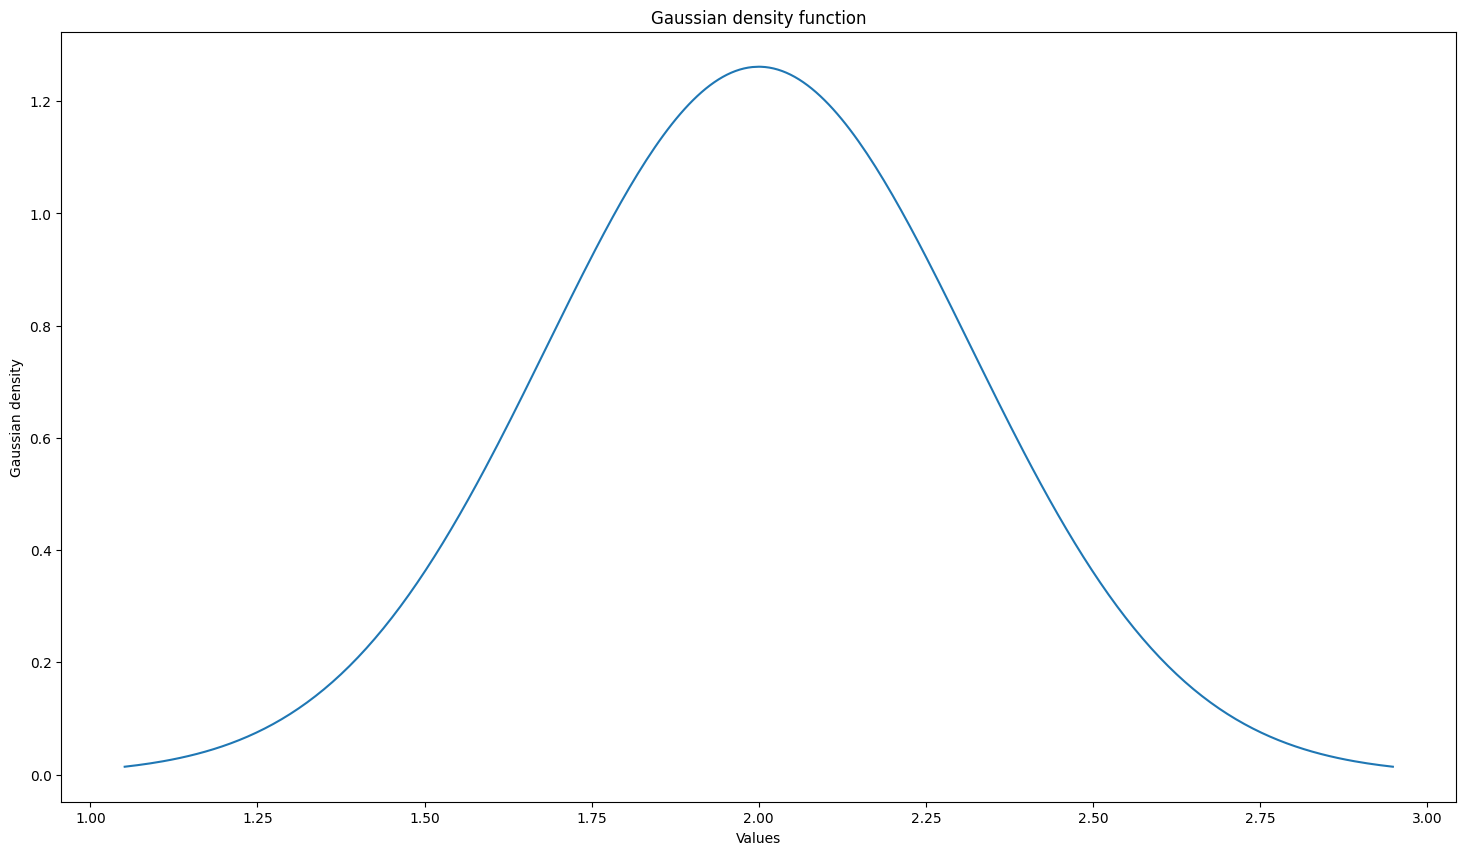

In [27]:
plt.figure(figsize=(18,10))
plt.plot(x, p)
plt.title("Gaussian density function")
plt.xlabel("Values")
plt.ylabel("Gaussian density")
plt.show()

In [28]:
def create_plot():
    '''
    create and prepare the 3 subplot figures to be used by the KF visualizer
    '''
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    axes[1, 0].set_axis_off()

    axes[0, 0].axvline(c='grey', lw=2)
    axes[0, 0].axhline(c='grey', lw=2)

    axes[0, 1].axvline(c='grey', lw=2)
    axes[0, 1].axhline(c='grey', lw=2)

    axes[1, 1].axvline(c='grey', lw=2)
    axes[1, 1].axhline(c='grey', lw=2)

    axes[0, 0].grid(visible=True)
    axes[0, 1].grid(visible=True)
    axes[1, 1].grid(visible=True)

    axes[0, 1].set_title('Function Model f', fontsize=30)

    axes[0, 0].set_xlabel('p(z)', fontsize=30)
    axes[0, 0].set_ylabel('output z', fontsize=30)

    axes[1, 1].set_xlabel('input x', fontsize=30)
    axes[1, 1].set_ylabel('p(x)', fontsize=30)

    return fig, axes

In [29]:
class Gaussian(object):
    def __init__(self, samples):
        self.num = len(samples)
        self.mean = self.calculate_mean(samples)
        self.var = self.calculate_covariance(samples)
        
    def calculate_mean(self, samples):
        mean = 0.0
        for x_i in samples:
            mean += x_i
        mean /= len(samples)
        return mean
    
    def calculate_covariance(self, samples):
        var = 0.0
        for x_i in samples:
            var += (x_i - self.mean)**2
        var /= len(samples)
        return var

Here is implemented monte carlo samples:
</br>
<img src="images/monte_carlo_steps.png"  width = 600 height=300 />

In [43]:
class MontoCarloSampler(object):
    def __init__(self, nl_model, mean, var, num):
        '''
        Monto-Carlo method is used to calculate the statistics of a random variable
        which undergoes a nonlinear transformation.
        
        nl_model: nonlinear model
        mean: mean of the input normal distribution
        var: variance of the input normal distribution
        num: number of random samples to be drawn from the distribution
        '''
        
        # 1. draw random samples from the normal distribution defined by mean and variance
        self.x_samples = np.random.normal(mean, var, num)
        
        # 2. calculate the pdf of the drawn samples from 'x'
        self.p_x_samples = gaussian_pdf(self.x_samples, mean, var)
        
        # 3. transform the drawn samples through the nonlinear model
        self.z_samples = nl_model(self.x_samples)
        
        # 4. calculate the mean and covariance of the transformed samples.
        z_gauss = Gaussian(self.z_samples)
        
        # 5. set other outputs
        self.num = num
        self.mean = z_gauss.mean
        self.var = z_gauss.var
        
        # 6. calculate the pdf of the transformed samples 'z'
        self.p_z_samples = gaussian_pdf(self.z_samples, z_gauss.mean, z_gauss.var)

In [51]:
mcs = MontoCarloSampler(non_lin_func, 10, 4, 300)
x_samples = mcs.x_samples
p_x_samples = mcs.p_x_samples
z_samples = mcs.z_samples
p_z_samples = mcs.p_z_samples

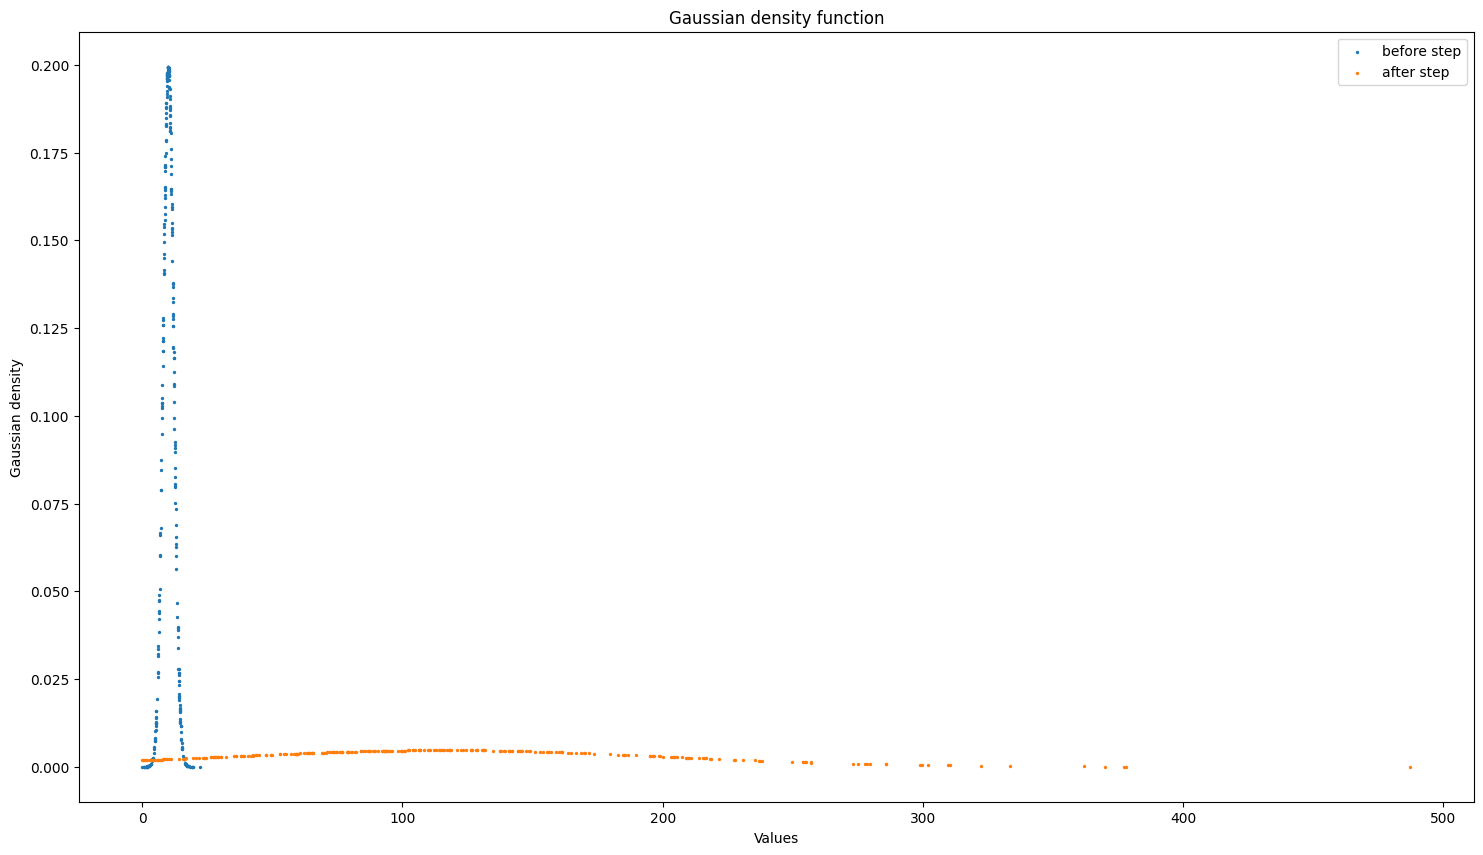

In [58]:
plt.figure(figsize=(18,10))
plt.scatter(x_samples, p_x_samples, s = 2, label = "before step")
plt.scatter(z_samples, p_z_samples, s = 2, label = "after step")
plt.title("Gaussian density function")
plt.xlabel("Values")
plt.ylabel("Gaussian density")
plt.legend()
plt.show()

In [31]:
class EKF_Visualization(object):
    def __init__(self, model=None, model_taylor=None, x_mean=0.0, x_sigma=0.0, samples_num=100, x_model_range=[-1., 1.], monto_carlo_sizes=[]):        
        '''
        initialize the class object
        
        model : model to be used for projection
        model_taylor : first order Taylor expansions of model f(x)
        
        x_mean : input mean
        x_sigma : input standard deviation
        
        x_model_range : range of values for plotting inputs of model and model_taylor
        z_model_range : range of values for plotting outputs of model and model_taylor
        
        '''
       
        self.xlim_min, self.xlim_max = x_model_range
               
        self.x_mean = x_mean
        self.x_sigma = x_sigma
        
        self.z_mean = model(self.x_mean)
               
        self.model = model
        self.model_taylor = model_taylor
        
        self.fig, self.axes = create_plot()
        
        self.monto_carlo_sizes = monto_carlo_sizes
        
    def update_plot(self):
        '''
        main function to execute the class plotting
        '''
        
        # ==============================================================================================
        # 1. generate 'x' samples to feed to the model 'f(x)'
        #
        x_norm_bel, p_norm_bel = generate_normal_samples(self.x_mean, self.x_sigma, num=50)
        x_norm_pts, p_norm_pts = generate_normal_samples(self.x_mean, self.x_sigma, num=8)
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 2. propagate the 'x' samples through model 'f(x)' to obtain 'z' samples
        #
        x_model_curve = np.linspace(self.xlim_min, self.xlim_max, num=100)
        z_model_curve = self.model(x_model_curve)
        
        z_norm_bel = self.model(x_norm_bel)
        z_norm_pts = self.model(x_norm_pts)
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 3. propagate the 'x' samples through the taylore expansion of model 'f(x)' to obtain 'z' samples
        #
        z_model_taylor = self.model_taylor(x_model_curve, self.x_mean, self.z_mean)
        z_norm_bel_taylor = self.model_taylor(x_norm_bel, self.x_mean, self.z_mean)
        z_norm_pts_taylor = self.model_taylor(x_norm_pts, self.x_mean, self.z_mean)
        # ==============================================================================================
        
        
        # ======z_model_taylor========================================================================================
        # 4. Monto-Carlo method: draw normally distributed random samples from 'x' and transform them
        #    through the nonlinear function f(x), then calculate mean and covariance of the 'z' outputs.
        #      
        monto_carlo_sampler_list = []
        z_monto_carlo_approx_list = []
        p_monto_carlo_approx_list = []
        
        for s in self.monto_carlo_sizes:
            monto_carlo_sampler = MontoCarloSampler(nl_model=self.model, mean=self.x_mean, var=self.x_sigma, num=s)
            z_monto_carlo_approx, p_monto_carlo_approx = generate_normal_samples(monto_carlo_sampler.mean, monto_carlo_sampler.var, num=50)
            
            monto_carlo_sampler_list.append(monto_carlo_sampler)
            z_monto_carlo_approx_list.append(z_monto_carlo_approx)
            p_monto_carlo_approx_list.append(p_monto_carlo_approx)
        
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 5. calculate the min and max samples to set plots limits
        #
       
        z_list = [z_norm_bel, z_norm_bel_taylor]
        p_list = [p_norm_bel]
        for i in range(len(z_monto_carlo_approx_list)):
            z_list.append(z_monto_carlo_approx_list[i])
            p_list.append(p_monto_carlo_approx_list[i])
            
        z_lim_min, z_lim_max = np.min(z_list), np.max(z_list)
        
        p_input_max = np.max(p_norm_bel) 
        p_output_max = np.max(p_list)
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 6. set plots limits
        #
        self.axes[0, 0].set_xlim(0., p_output_max)
        self.axes[0, 0].set_ylim(z_lim_min, z_lim_max)
        
        self.axes[1, 1].set_xlim(self.xlim_min, self.xlim_max)
        self.axes[1, 1].set_ylim(0., p_input_max)
        
        self.axes[0, 1].set_xlim(self.xlim_min, self.xlim_max)
        self.axes[0, 1].set_ylim(z_lim_min, z_lim_max)
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 7. plot input normal distribution
        #
        self.axes[1, 1].plot(x_norm_bel, p_norm_bel, color='blue', label='input normal distribution')
        if (len(monto_carlo_sampler_list) == 1):
            self.axes[1, 1].plot(monto_carlo_sampler_list[0].x_samples, monto_carlo_sampler_list[0].p_x_samples, color='red', marker='o', linestyle='', label='input drawn samples') # plot samples
        # ==============================================================================================
    
    
        # ==============================================================================================
        # 8. plot output normal distributions
        # 
        self.axes[0, 0].plot(p_norm_bel, z_norm_bel, color='blue', label='output normal distribution')
        
        if (len(monto_carlo_sampler_list) == 1):
            self.axes[0, 0].plot(monto_carlo_sampler_list[0].p_z_samples, monto_carlo_sampler_list[0].z_samples, color='red', marker='o', linestyle='', label='output transformed samples') # plot samples
        
        self.axes[0, 0].plot(p_norm_bel, z_norm_bel_taylor, color='orange', label='Taylor-1st-Order Distribution')
        
        for i in range(len(monto_carlo_sampler_list)):
            self.axes[0, 0].plot(p_monto_carlo_approx_list[i], z_monto_carlo_approx_list[i], color='black', linestyle=':', label=f'monto-carlo approx N={monto_carlo_sampler_list[i].num}, [mean={round(monto_carlo_sampler_list[i].mean,2)}, var={round(monto_carlo_sampler_list[i].var,2)}]')
        # ==============================================================================================
    
    
        # ==============================================================================================
        # 9. plot model curve
        #        
        self.axes[0, 1].plot(x_model_curve, z_model_curve, color='blue', label='non-linear model f(x)=x')
        
        if (len(monto_carlo_sampler_list) == 1):
            self.axes[0, 1].plot(monto_carlo_sampler_list[0].x_samples, monto_carlo_sampler_list[0].z_samples, color='red', marker='o', linestyle='', label='input/output samples') # plot samples
            
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 10. plot model first order taylor curve
        #   
        self.axes[0, 1].plot(x_model_curve, z_model_taylor, color='orange', label='first order taylor of f(x)')
        # ==============================================================================================

        self.axes[0, 0].legend(loc='upper right')
        self.axes[0, 1].legend(loc='upper right')
        self.axes[1, 1].legend(loc='upper right')
        

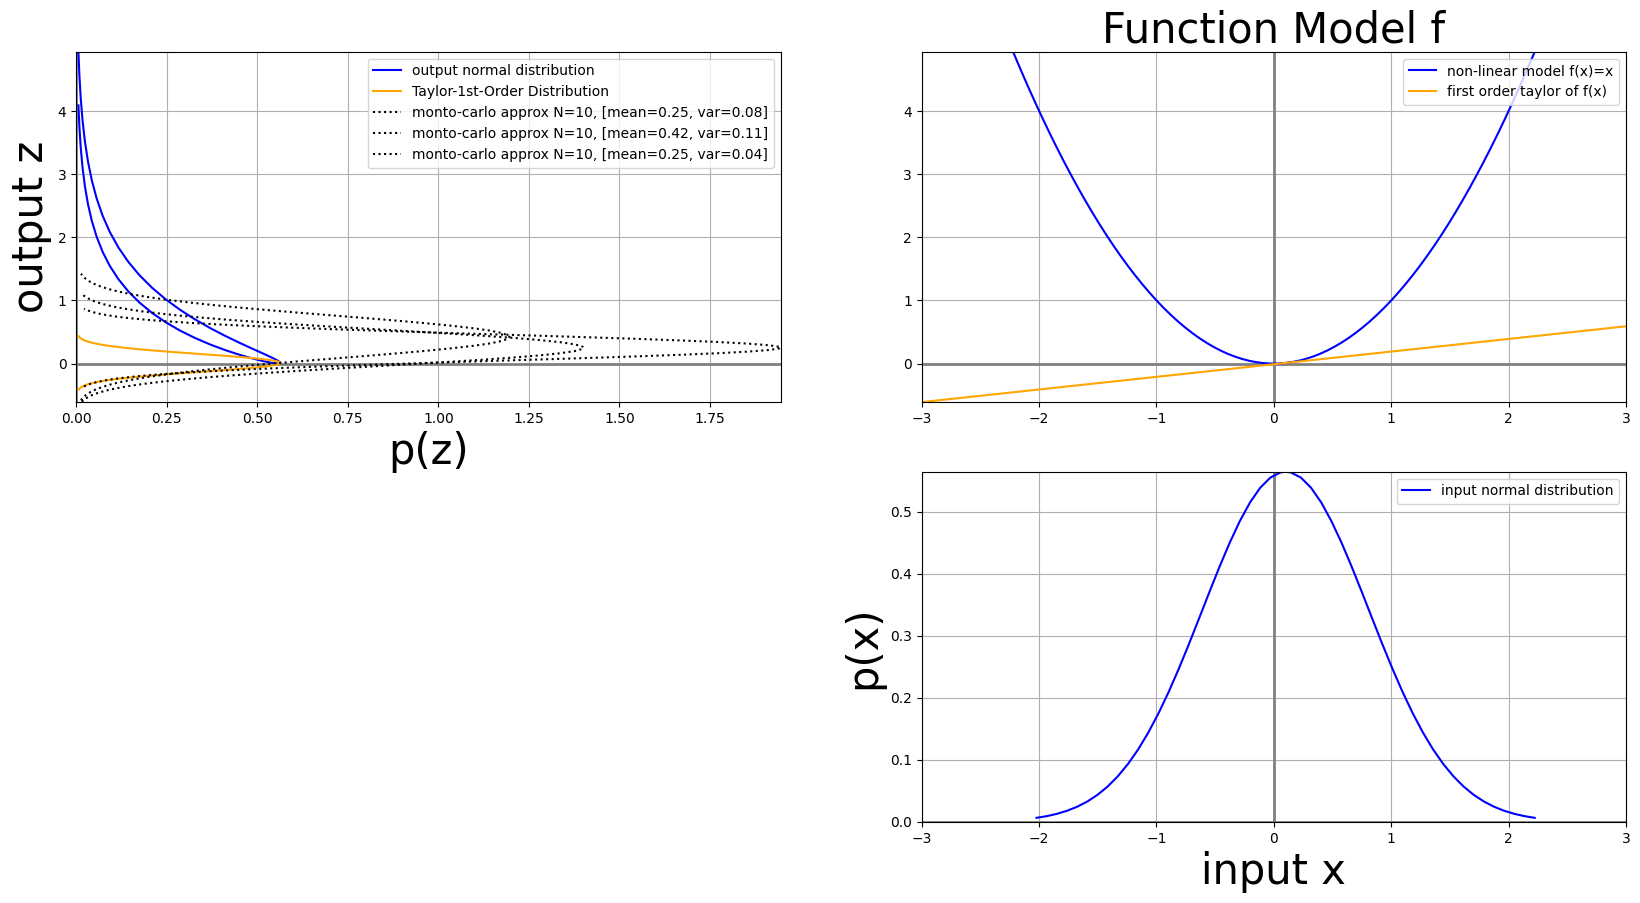

In [32]:
x_range, x_num = (-3., 3.), 100
x_mean, x_sigma = 0.1, 0.5

ekf_visu = EKF_Visualization(
    model=non_lin_func,
    model_taylor=f_taylor_order_1,
    x_mean=x_mean, x_sigma=x_sigma,
    x_model_range=x_range,
    samples_num=100,
    monto_carlo_sizes=[10, 10, 10])

ekf_visu.update_plot()